In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
#try:
#    os.chdir("L:\laupodteam\AIOS\Huibert-Jan\Celldynclustering\celldyn_embedder")
#except FileNotFoundError:
#    os.chdir('C:/Users/Huibert-Jan/Documents/Werk/UMCU/celldyn_embedder')    

import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pacmap
import umap
import trimap

#from scipy.stats import chisquare, chi2_contingency, pearsonr
#from scipy.stats import kendalltau,spearmanr, weightedtau, theilslopes, wilcoxon, ttest_rel
#from scipy.spatial import distance
#import dcor

from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#from sklearn.decomposition import PCA
#from sklearn.manifold import Isomap, MDS, SpectralEmbedding
from sklearn.manifold import LocallyLinearEmbedding as LLE, TSNE, smacof, trustworthiness
from sklearn.cluster import KMeans, BisectingKMeans, OPTICS, affinity_propagation, AgglomerativeClustering
# add GMM
from sklearn.mixture import GaussianMixture as GMM, BayesianGaussianMixture as BGMM

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

import skfuzzy as fuzz


#from sklearn.metrics import rand_score, adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
#from sklearn.neighbors import KNeighborsClassifier as KNN
#from sklearn.cluster import KMeans

from hembedder.utils.distance import poincarre_dist, hyperboloid_dist, fractional_distance, Distance
from hembedder.utils.quality_metrics import CDEmbeddingPerformance
#import numpy.linalg as la
#import torch 

#from numba import njit

#import faiss
import gc

from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
from scipy.stats import entropy

from tqdm import tqdm

from pysr import PySRRegressor
from gplearn.genetic import SymbolicTransformer
from sklego.meta import ZeroInflatedRegressor
#from lineartree import LinearTreeRegressor, LinearForestRegressor

from xgboost import XGBRegressor, XGBRFClassifier

from typing import List, Tuple, Iterable, Callable

import random


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# take class BGMM and extend with a function called bic
class BGMM(BGMM):
    def _n_parameters(self, X):
          """Return the number of free parameters in the model."""
          _, n_features = self.means_.shape
          # Number of effective components equals the number of unique labels
          n_effect_comp = len(np.unique(self.predict(X)))
          #n_effect_comp = self.n_components
          if self.covariance_type == 'full':
              cov_params = n_effect_comp * n_features * (n_features + 1) / 2.
          elif self.covariance_type == 'diag':
              cov_params = n_effect_comp * n_features
          elif self.covariance_type == 'tied':
              cov_params = n_features * (n_features + 1) / 2.
          elif self.covariance_type == 'spherical':
              cov_params = n_effect_comp
          mean_params = n_features * n_effect_comp
          return int(cov_params + mean_params + n_effect_comp - 1)

    def bic(self, X):
        """Bayesian information criterion for the current model on the input X.

        Parameters
        ----------
        X : array of shape (n_samples, n_dimensions)

        Returns
        -------
        bic : float
            The lower the better.
        """
        return (-2 * self.score(X) * X.shape[0] + self._n_parameters(X) * np.log(X.shape[0]))

    def aic(self, X):
        """Akaike information criterion for the current model on the input X.

        Parameters
        ----------
        X : array of shape (n_samples, n_dimensions)
+
        Returns
        -------
        aic : float
            The lower the better.
        """
        return -2 * self.score(X) * X.shape[0] + 2 * self._n_parameters(X)


In [4]:
def cluster_classification_f1(X, labels):
    '''
        create a logistic regression classifier to predict cluster labels
        , determine the stratified cross-validated F1 score of the model.
    '''
    # create a logistic regression classifier to predict cluster labels
    clf = LogisticRegression(random_state=0, penalty='elasticnet', solver='saga', l1_ratio=0.1,
                                multi_class='multinomial', max_iter=5000)

    # determine the stratified cross-validated F1 score of the model.
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    f1_scores = []
    for train_index, test_index in skf.split(X, labels):
        clf.fit(X[train_index], labels[train_index])
        f1_scores.append(f1_score(labels[test_index], clf.predict(X[test_index]), average='weighted'))

    return np.mean(f1_scores), np.std(f1_scores)

In [5]:
# a function to run a clustering algorithm in a bootstrapping fashion
# the outcome is a list of clustering models
def clustering_bootstrapping(data: pd.DataFrame, 
                             n_clusters: int=10,
                             n_bootstraps: int=100, 
                             sample_size: int=50000,
                             clusterer: str='kmeans',
                             align: bool=False,
                             **kwargs)-> List[Callable]:
    if kwargs.get('n_init', None) is None:
        n_init = 10
    else:
        n_init = kwargs.get('n_init')
    
    model_list = []
    for i in tqdm(range(n_bootstraps)):
        # sample data
        sample = data.sample(sample_size, replace=True)
        # cluster sample
        if clusterer == 'kmeans':
            if (i==0) | (align==False):
                model = KMeans(n_clusters=n_clusters, random_state=123, n_init=n_init)
                model.fit(sample)
                init_means = model.cluster_centers_
            else:
                model = KMeans(n_clusters=n_clusters, random_state=123, init=init_means, n_init=n_init)
                model.fit(sample)
        elif clusterer == 'optics':
            model = OPTICS(min_samples=100, n_jobs=-1)
            model.fit(sample)
        elif clusterer == 'hierarchical':
            model = AgglomerativeClustering(n_clusters=n_clusters)
            model.fit(sample)
        elif clusterer == 'gmm':
            if (i==0) | (align==False):
                model = GMM(n_components=n_clusters, random_state=123)
                model.fit(sample)
                init_means = model.means_
            else:
                model = GMM(n_components=n_clusters, random_state=123, means_init=init_means)
                model.fit(sample)
        elif clusterer == 'bgmm':
            if (i==0) | (align==False):
                model = BGMM(n_components=n_clusters, random_state=123, max_iter=500)
                model.fit(sample)
                init_means = model.mean_prior_
            else:
                model = BGMM(n_components=n_clusters, random_state=123, mean_prior=init_means, max_iter=500)
                model.fit(sample)
        else:
            raise ValueError("Unknown clustering algorithm")
        model_list.append(model)
    return model_list
    
def assign_clusters(data: pd.DataFrame, 
                    model_list: List[Callable], 
                    clusterer='kmeans') -> pd.DataFrame:
    
    # get cluster labels
    if clusterer in ['kmeans']:
        labels = np.array([model.predict(data) for model in model_list])
        # get cluster centers
        centers = np.array([model.cluster_centers_ for model in model_list])
        # get cluster sizes
        sizes = np.array([np.bincount(label, minlength=centers.shape[1]) for label in labels])
    elif clusterer in ['gmm', 'bgmm']:
        labels = np.array([model.predict(data) for model in model_list])
        # get cluster centers
        centers = np.array([model.means_ for model in model_list])
        # get cluster sizes
        sizes = np.array([np.bincount(label, minlength=centers.shape[1]) for label in labels])        
    return labels, centers, sizes 


def distance(v1, v2, metric='euclidean'):
    ''' Calculate the distance between two vectors '''
    if metric=='euclidean':
        return np.linalg.norm(v1 - v2)
    elif metric=='cosine':
        return 1 - np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    elif metric=='poincarre':
        return poincarre_dist(v1, v2)
    elif metric=='manhattan':
        return np.linalg.norm(v1 - v2, ord=1)

In [6]:
celldyn_full = pd.read_feather("L:/laupodteam/AIOS/Bram/data/CellDyn/artifacts/celldyn_FULL_transformed_df_updated.feather")

meas_columns = [c for c in celldyn_full.columns if ('c_b' in c) | ("COMBO" in c)]
mode_columns = [c for c in celldyn_full.columns if 'c_m' in c]
alrt_columns = [c for c in celldyn_full.columns if 'alrt' in c.lower()]
c_s_columns = [c for c in celldyn_full.columns if 'c_s_' in c.lower()]
celldyn_full.drop(['index'], axis=1, inplace=True)

celldyn_full = celldyn_full.assign(gender=celldyn_full.gender.map({'M':0, 'F':1}))
celldyn_full.dropna(subset=['gender','draw_hour'], axis=0, inplace=True)
celldyn_full.rename(columns={'studyid_alle_celldyn':'study_id', 'afname_dt': 'sample_dt'}, inplace=True)
celldyn_full.set_index(['study_id', 'sample_dt'], inplace=True)

In [7]:
celldyn_emb = pd.read_feather("L:\laupodteam\AIOS\Bram\data/CellDyn/artifacts/umap_euclidean_euclidean_spectral_dims_6_n_n_50_n_epochs_400_densmap_True_embedded_data.feather")
celldyn_emb = celldyn_emb.assign(sex=celldyn_emb.sex.map({'M':0, 'F':1}))
celldyn_emb.dropna(subset=['sex','draw_hour'], axis=0, inplace=True)
celldyn_emb.set_index(['study_id', 'sample_dt'], inplace=True)
celldyn_emb = celldyn_emb.loc[celldyn_full.index]

In [8]:
in_full = celldyn_full.reset_index()[['study_id', 'sample_dt']].drop_duplicates()
in_emb = celldyn_emb.reset_index()[['study_id', 'sample_dt']].drop_duplicates()

## Feature selection using sparse coding



## Feature expansion using  symbolic regression

## Blob metrics

* We use the density profiles from HDBSCAN to characterize the blobbiness of the data
* We use fuzzy c-means in combination with AUFPC curves

In [9]:
from hdbscan import HDBSCAN

sample_size = 100000
selection = in_full.sample(sample_size).reset_index(drop=True)

kwargs = {
    'min_cluster_size': 5, 
    'min_samples': 15, 
    'metric': 'manhattan',
    'cluster_selection_method':'leaf'    
}

emb_index = celldyn_emb[celldyn_emb.index.isin(selection.itertuples(index=False))].index.drop_duplicates()
full_index = celldyn_full[celldyn_full.index.isin(selection.itertuples(index=False))].index.drop_duplicates()


In [9]:
#plt.hist(pipeline.named_steps['hdbscan'].probabilities_, bins=100);
#pipeline.named_steps['clusterer'].condensed_tree_\
#        .plot(select_clusters=True,selection_palette=sns.color_palette('deep', 8))

In [11]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from sklearn.decomposition import PCA

In [54]:
Ranker = FunctionTransformer(lambda x: np.argsort(np.argsort(x, axis=0), axis=0))

In [10]:
#clusterer = OPTICS(min_samples=15, metric='canberra', n_jobs=-1)
#clusterer = HDBSCAN(**kwargs)
clusterer = KMeans(n_clusters=10, random_state=123)
df = celldyn_full.loc[full_index].reset_index().groupby(['study_id', 'sample_dt']).first()

pipeline_emb = Pipeline([('scaler', StandardScaler()),
                         ('embedder', umap.UMAP(n_components=3, n_neighbors=500, n_epochs=500,
                                                metric='manhattan', init='spectral',
                                                random_state=123, densmap=False, min_dist=0)), 
                         ('clusterer', clusterer)], verbose=True)
pipeline_emb.fit(df.loc[:, meas_columns])

#pipeline_emb = clusterer.fit(
#                trimap.TRIMAP(n_dims=3, n_inliers=12, n_outliers=4, distance='manhattan', n_iters=500, lr=0.09).fit_transform(
#                    StandardScaler().fit_transform(df[meas_columns])
#    )
#)

#pipeline_emb = Pipeline([('scaler', StandardScaler()),
#                         ('Embedder', pacmap.PaCMAP(n_components=3, n_neighbors=500, num_iters=500, lr=0.9, apply_pca=False)), 
#                         ('clusterer', clusterer)], verbose=True
#                        )
#pipeline_emb.fit(df.loc[:, meas_columns])

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.1s
[Pipeline] .......... (step 2 of 3) Processing embedder, total=14.3min


c:\Users\bes3\VIRTUALENVS\embedder\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[Pipeline] ......... (step 3 of 3) Processing clusterer, total=   1.8s


Pipeline(steps=[('scaler', StandardScaler()),
                ('embedder',
                 UMAP(metric='manhattan', min_dist=0, n_components=3, n_epochs=500, n_neighbors=500, random_state=123, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})),
                ('clusterer', KMeans(n_clusters=10, random_state=123))],
         verbose=True)

In [59]:
#clusterer = OPTICS(min_samples=15, metric='canberra', n_jobs=-1)
#clusterer = HDBSCAN(**kwargs)
clusterer = KMeans(n_clusters=10, random_state=123)

df = celldyn_full.loc[full_index].reset_index().groupby(['study_id', 'sample_dt']).first()

pipeline_full = Pipeline([('scaler', StandardScaler()), 
                          ('ranker', Ranker),
                          ('clusterer', clusterer)])
pipeline_full.fit(df.loc[:, meas_columns])

Pipeline(steps=[('scaler', StandardScaler()),
                ('ranker',
                 FunctionTransformer(func=<function <lambda> at 0x000001E693AAF010>)),
                ('clusterer',
                 HDBSCAN(cluster_selection_method='leaf', metric='manhattan',
                         min_samples=15))])

In [55]:
#clusterer = OPTICS(min_samples=15, metric='canberra', n_jobs=-1
#clusterer = HDBSCAN(**kwargs)
clusterer = KMeans(n_clusters=10, random_state=123)

df = celldyn_full.loc[full_index].reset_index().groupby(['study_id', 'sample_dt']).first()

pipeline_pca = Pipeline([('scaler', StandardScaler()), 
                          ('pca', PCA(n_components=3, whiten=False)),
                          ('ranker', Ranker),
                          ('clusterer', clusterer)], verbose=True)
pipeline_pca.fit(df.loc[:, meas_columns])

[Pipeline] ............ (step 1 of 4) Processing scaler, total=   0.2s
[Pipeline] ............... (step 2 of 4) Processing pca, total=   0.5s
[Pipeline] ............ (step 3 of 4) Processing ranker, total=   0.0s
[Pipeline] ......... (step 4 of 4) Processing clusterer, total=   7.6s


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=3)),
                ('ranker',
                 FunctionTransformer(func=<function <lambda> at 0x000001E693AAF010>)),
                ('clusterer',
                 HDBSCAN(cluster_selection_method='leaf', metric='manhattan',
                         min_samples=15))],
         verbose=True)

In [14]:
from sklearn.metrics import adjusted_rand_score as ARI, normalized_mutual_info_score as NMI

In [56]:
Xpca = pipeline_pca.named_steps['pca'].transform(df.loc[:, meas_columns])
Xemb = pipeline_emb.named_steps['embedder'].embedding_
Xorg = df.loc[:, meas_columns].values
perfClass = CDEmbeddingPerformance(n_neighbours=500, metric='manhattan', dcor_level=1)

c:\Users\bes3\VIRTUALENVS\embedder\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


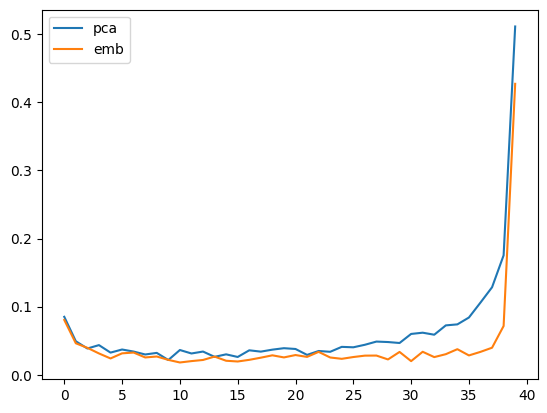

In [57]:
rnd_sel = np.random.randint(0,100_000, 2000)
plt.plot(perfClass._return_dynamic_distance_correlation(Xpca[rnd_sel], Xorg[rnd_sel], n_bins=40))
plt.plot(perfClass._return_dynamic_distance_correlation(Xemb[rnd_sel], Xorg[rnd_sel], n_bins=40))
plt.legend(['pca', 'emb'])

In [60]:
# ARI, NMI
emb_labels = pipeline_emb.named_steps['clusterer'].labels_
#emb_labels = pipeline_emb.labels_

full_labels = pipeline_full.named_steps['clusterer'].labels_
pca_labels = pipeline_pca.named_steps['clusterer'].labels_

print(f"ARI: {ARI(emb_labels, full_labels)}")
print(f"NMI: {NMI(emb_labels, full_labels)}")

print(f"ARI PCA: {ARI(pca_labels, full_labels)}")
print(f"NMI PCA: {NMI(pca_labels, full_labels)}")

print(f"num embedding labels: {len(np.unique(emb_labels))}")
print(f"num full labels: {len(np.unique(full_labels))}")
print(f"num pca labels: {len(np.unique(pca_labels))}")

ARI: 0.002372267731901385
NMI: 0.023155929621659365
ARI PCA: 6.44463414371119e-05
NMI PCA: 0.008117014663662441
num embedding labels: 10
num full labels: 20
num pca labels: 815


In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(20, 12)) 

ordering = pipeline_emb.named_steps['clusterer'].ordering_
reach = pipeline_emb.named_steps['clusterer'].reachability_[ordering]
labels = pipeline_emb.named_steps['clusterer'].labels_[ordering]
space = np.arange(labels.shape[0])
num_categories = len(np.unique(labels))
colormap = cm.get_cmap('viridis', num_categories)
colors = [colormap(i) for i in range(num_categories)]

for klass, color in zip(range(0, num_categories), colors):
    Xk = space[labels == klass]
    Rk = reach[labels == klass]
    ax[0].plot(Xk, Rk, color, alpha=0.8)
ax[0].plot(space[labels == -1], reach[labels == -1], "k.", alpha=0.3)
#ax[0].plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
#ax[0].plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax[0].set_ylabel("Reachability (epsilon distance)")
ax[0].set_xlim(1,15000)


############################################################################################################
############################################################################################################
############################################################################################################

ordering = pipeline_full.named_steps['clusterer'].ordering_
reach = pipeline_full.named_steps['clusterer'].reachability_[ordering]
labels = pipeline_full.named_steps['clusterer'].labels_[ordering]
space = np.arange(labels.shape[0])
num_categories = len(np.unique(labels))
colormap = cm.get_cmap('viridis', num_categories)
colors = [colormap(i) for i in range(num_categories)]

for klass, color in zip(range(0, num_categories), colors):
    Xk = space[labels == klass]
    Rk = reach[labels == klass]
    ax[1].plot(Xk, Rk, color, alpha=0.3)
ax[1].plot(space[labels == -1], reach[labels == -1], "k.", alpha=0.3)
#ax[1].plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
#ax[1].plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax[1].set_ylabel("Reachability (epsilon distance)")
ax[1].set_xlim(1,15000)
ax[1].set_ylim(20,40)

fig.suptitle("Reachability Plot")


## Bootstrapped Clustering

In [ ]:
gc.collect()
bclusters = clustering_bootstrapping(celldyn_full[meas_columns], n_clusters=10, n_bootstraps=60, sample_size=10000, clusterer='kmeans', n_init=1, align=True)
gc.collect()

In [ ]:
test_set = celldyn_full.sample(10000, replace=True)[meas_columns]
labels, centers, sizes = assign_clusters(test_set, bclusters, clusterer='kmeans')

In [ ]:
from sklearn.metrics.cluster import fowlkes_mallows_score, homogeneity_score, homogeneity_completeness_v_measure
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score, adjusted_mutual_info_score, pair_confusion_matrix

cluster_overlap_list = []
for i in range(labels.shape[0]):
    for j in range(i+1, labels.shape[0]):
        cluster_overlap_list.append(fowlkes_mallows_score(labels[i], labels[j]))

plt.hist(cluster_overlap_list, bins=30);

In [ ]:
# we want to re-order the cluster labels for each model such that the ordinal similarity between the models is maximized
init_sim = np.sum(np.corrcoef(labels))/labels.shape[0]**2
print(f"Initial similarity: {init_sim}")

#  we want to align the cluster id's based on the cluster centers or the cluster assignmnents
def align_cluster_assignments(labels: np.ndarray, centers: np.ndarray, method: str='centerwise', base_sel: int=0)-> np.ndarray:
    '''
        Centerwise, given, 1..N models, we align the 2,N models based on the cluster centers of model 1.
        I.e. we find the cluster center in model 2 that is closest to the cluster center in model 1 and assign the cluster id's accordingly
    '''
    if method == 'centerwise':
        base_centers = centers[base_sel]
        # find the closest cluster center for each model
        closest_centers = [[np.argmin([distance(bv.ravel(), _cv.ravel(), metric='cosine') 
                                            for _cv in cv]) 
                                                for bv in base_centers] 
                                                    for cv in centers[1:]
                                                    ]
        # now we have the closest cluster centers for each model, we can re-order the labels
        aligned_labels = [np.array([closest_centers[i][l] for l in labels[base_sel]]) for i in range(len(closest_centers))]
        aligned_centers = [centers[i][closest_centers[i]] for i in range(len(closest_centers))]

    '''
        TODO:
    	We want to re-order the cluster labels for each model such that the ordinal similarity between the models is maximized.
        We express this similarity with MCC (Matthews correlation coefficient)
    '''
    # first order the labels from the first model, use the order index
    # to order the labels of the other models

    # now change the labels of the other models to match the order of the first model


    return np.vstack(aligned_labels), np.stack(aligned_centers), closest_centers

aligned_labels, aligned_centers, closest_centers = align_cluster_assignments(labels, centers, method='centerwise', base_sel=0)
print(f"Aligned result: {np.sum(np.corrcoef(aligned_labels))/aligned_labels.shape[0]**2}")

In [ ]:
cluster_assignment = pd.DataFrame(aligned_labels.T, columns=['cluster_assignment_'+str(i) for i in range(aligned_labels.shape[0])])
cluster_assignment.index = test_set.index
cluster_assignment = cluster_assignment.assign(cluster_entropy=cluster_assignment.apply(lambda x: entropy(np.histogram(x, bins=10, density=True)[0]), axis=1))
cluster_assignment = cluster_assignment.assign(median_cluster=cluster_assignment.apply(lambda x: int(np.median(x)), axis=1))

In [ ]:
plot_df = celldyn_emb.loc[cluster_assignment.index].join(cluster_assignment[['cluster_entropy', 'median_cluster']], how='inner')
sns.scatterplot(data=plot_df, x='dim_2', y='dim_3', hue='median_cluster', palette='viridis', alpha=0.5, legend=True)

In [ ]:
cluster_num = 0
for plot_count in range(100):
    _v1, _v2 = random.sample(range(0, aligned_centers.shape[2]), 2)
    if _v1 != _v2:
        v1 = aligned_centers[:, cluster_num, _v1]
        v2 = aligned_centers[:, cluster_num, _v2]
        plt.scatter(v1, v2, c='r', alpha=0.05)
plt.title(f"Cluster-center spread for cluster {cluster_num}")

## NMI and ARI

## Fuzzy c-means

In [ ]:
fpcs = []

df =celldyn_full[meas_columns] # ['age',  'gender']]
#df = celldyn_emb[['dim_1', 'dim_2', 'dim_3', 'dim_4',  'dim_5', 'dim_6']]
n_bootstrap = 30
sample_count = 50000
for n in tqdm(range(n_bootstrap)):
    data = df.sample(sample_count)
    _idx = data.index
    
    _fpcs = []
    for ncenters, ax in enumerate(range(10),2):
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T.values, c=ncenters, m=1.1, 
                                        error=0.005, maxiter=1000, init=None, seed=123)

        # Store fpc values for later
        _fpcs.append(fpc)
    fpcs.append(_fpcs)

for i in range(n_bootstrap):
    plt.plot(np.arange(2, 12), fpcs[i], alpha=0.1, c='b')

plt.xlabel("Number of centers")
plt.ylabel("Fuzzy partition coefficient")

## GMM evaluation

* use ```model.aic``` and ```model.bic``` to evaluate GMM
* use ```model.score_samples``` to evaluate BGMM

In [ ]:
# get sample data
res_list = []
n_bootstrap = 10
sample_count = 5000
n_clusters = 20

df =celldyn_full[meas_columns] 
#df = celldyn_emb[['dim_1', 'dim_2', 'dim_3', 'dim_4',  'dim_5', 'dim_6', 'age', 'sex']]
cluster_sizes = []
for b in range(n_bootstrap):
    data = df.sample(sample_count)
    # extract the cluster centers and aic, bic using GMM for 1..10 clusters
    
    for n in range(2, n_clusters+1):
        gmm = GMM(n_components=n, covariance_type='full', random_state=123, max_iter=1000).fit(data)
        labels = gmm.predict(data)
        cluster_sizes.append(np.bincount(labels))

        #centers = gmm.means_
        aic = gmm.aic(data)
        bic = gmm.bic(data)
        silhouette_avg = silhouette_score(data, labels)
        davies_bouldin = davies_bouldin_score(data.values, labels)
        calinski_harabasz = calinski_harabasz_score(data.values, labels)
        mean_log_likelihood = gmm.score(data)

        # only keep the samples that are assigned to clusters with more than 50 samples
        # this is to avoid the problem of having too few samples in a cluster
        # and thus the cluster classification f1 score is not reliable

        f1, f1_std = cluster_classification_f1(data.values, labels)
        res_list.append({'bootstrap_round': b, 
                         'num_cluster': n, 
                         'AIC': aic, 
                         'BIC': bic, 
                         'silhouette_score': silhouette_avg,
                         'davies_bouldin_score': davies_bouldin,
                         'calinski_harabasz_score': calinski_harabasz,
                         'score': mean_log_likelihood,
                         'f1': f1,
                         'f1_std': f1_std})
res_df = pd.DataFrame(res_list)

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(18, 25))

sns.lineplot(data=res_df, x='num_cluster', y='AIC', alpha=0.1, c='b',  ax=ax[0,0])
sns.lineplot(data=res_df, x='num_cluster', y='BIC', alpha=0.1, c='b',  ax=ax[0,1])

sns.lineplot(data=res_df, x='num_cluster', y='silhouette_score', alpha=0.1, c='b',  ax=ax[1,0])
sns.lineplot(data=res_df, x='num_cluster', y='davies_bouldin_score', alpha=0.1, c='b',  ax=ax[1,1])

sns.lineplot(data=res_df, x='num_cluster', y='calinski_harabasz_score', alpha=0.1, c='b',  ax=ax[2,0])
sns.lineplot(data=res_df, x='num_cluster', y='score', alpha=0.1, c='b',  ax=ax[2,1])

sns.lineplot(data=res_df, x='num_cluster', y='f1', alpha=0.1, c='b',  ax=ax[3,0])
sns.lineplot(data=res_df, x='num_cluster', y='f1_std', alpha=0.1, c='b',  ax=ax[3,1])

fig.suptitle("GMM clustering, bootstrap N=10, sample size=5000")
ax[0,0].set_title("AIC")
ax[0,1].set_title("BIC")

ax[1,0].set_title("Silhouette score")
ax[1,1].set_title("David Bouldin score")

ax[2,0].set_title("Calinski Harabasz score")
ax[2,1].set_title("Mean log likelihood")

ax[3,0].set_title("F1 score")
ax[3,1].set_title("F1 score std")


In [ ]:
res_df

In [ ]:
# get sample data
res_list = []
n_bootstrap = 20
sample_count = 10000
n_clusters = 20

df =celldyn_full[meas_columns] 
#df = celldyn_emb[['dim_1', 'dim_2', 'dim_3', 'dim_4',  'dim_5', 'dim_6', 'age', 'sex']]
for b in tqdm(range(n_bootstrap)):
    data = df.sample(sample_count)
    # extract the cluster centers and aic, bic using GMM for 1..10 clusters    
    
    gmm = BGMM(n_components=n_clusters, covariance_type='full', random_state=123, max_iter=1000).fit(data)
    #labels = gmm.predict(data)
    #centers = gmm.means_
    res_list.append({'bootstrap_round': b, 
                     'mean_log_likelihood': gmm.score(data)})
res_df = pd.DataFrame(res_list)

In [ ]:
df =celldyn_full[meas_columns] 
data = df.sample(1000)
n_comp = 3
gmm = BGMM(n_components=n_comp, covariance_type='full', random_state=123, max_iter=1000).fit(data)
bgmm_res = gmm.predict_proba(data)
AIC = gmm.aic(data)
BIC = gmm.bic(data)
data['log_likelihood_gmm'] = gmm.score_samples(data)
data[[f'cluster_{i}' for i in range(n_comp)]] = bgmm_res
res_df = pd.DataFrame(data=bgmm_res, columns=[f'cluster_{i}' for i in range(n_comp)])
res_df.index=data.index


In [ ]:
data[[f'cluster_{i}' for i in range(n_comp)]].mean()

In [ ]:
AIC, BIC

In [ ]:
clust = 'cluster_2'
plot_df = celldyn_emb.loc[data.index].join(data[['log_likelihood_gmm', clust]], how='inner')
sns.scatterplot(data=plot_df[plot_df.log_likelihood_gmm>=0], x='dim_1', y='dim_3', hue=clust, palette='viridis', alpha=0.5, legend=True)
sns.scatterplot(data=plot_df[plot_df.log_likelihood_gmm<0], x='dim_1', y='dim_3', color='black', alpha=0.1, legend=True)
